In [216]:
import pandas as pd
import numpy as np
col = ["scheduled_off","full_description","competition","competition_type","event_name",
"team1","team2","1","x","2","vol_1","vol_x","vol_2","bet_1","bet_x","bet_2","favorite_odd","favorite_flag","winner","IP_1","IP_x",
"IP_2","min_from_start_1","min_from_start_x","min_from_start_2","vm_ep_1","vm_ep_x","vm_ep_2","prob_1","prob_x","prob_2","pnl_1","pnl_x","pnl_2"]
types = [str, str, str, str, str, str, str, float, float, float, float, float ,float, float, 
         float, float, float ,str, str, str, str, str, float, float, float,  float, float, float]
types = {col:t for col, t in zip(col, types)}
data = pd.read_csv("favorites.csv", header = 0, index_col = 0, encoding = "cp1252", sep = ";", dtype = types, na_values = ["\\N"])
data = data.reset_index()

In [201]:
data["execution_times"] = np.abs(data["min_from_start_1"].fillna(300) - data["min_from_start_2"].fillna(600)) \
                        + np.abs(data["min_from_start_1"].fillna(300) - data["min_from_start_x"].fillna(600)) \
                        + np.abs(data["min_from_start_2"].fillna(300) - data["min_from_start_x"].fillna(600))
data["execution_times"] = data["execution_times"]

data["prob_1"] = 1/ data["1"]
data["prob_x"] = 1/ data["x"]
data["prob_2"] = 1/ data["2"]
data["sum_prob"] = data["prob_1"]+data["prob_x"]+data["prob_2"]
data["1"] = data["1"] * data["sum_prob"]
data["2"] = data["2"] * data["sum_prob"]
data["x"] = data["x"] * data["sum_prob"]

In [217]:
data["execution_times"][data["execution_times"] < 10].hist(bins = 100)

plt.show()
data = data[data["execution_times"] < 10]

KeyError: 'execution_times'

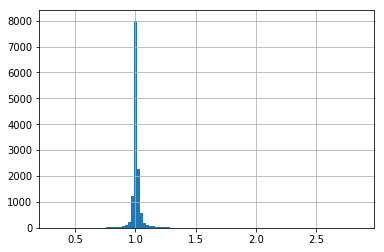

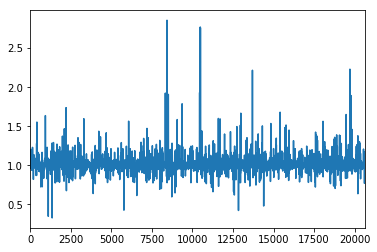

count    13293.000000
mean         1.007268
std          0.064302
min          0.327697
25%          0.993939
50%          1.001207
75%          1.011629
max          2.857143
Name: sum_prob, dtype: float64

In [203]:
data["sum_prob"].hist(bins = 100)
plt.show()
data["sum_prob"].plot()
plt.show()
data["sum_prob"].describe()

In [204]:
def split_team(s, i):
    if isinstance(s, str):
        teams = s.split(" v ")
        if len(teams) > i:
            return teams[i]
        else:
            return None
    else:
        return None

data["team1"] = data["event_name"].apply(lambda x: split_team(x,0))
data["team2"] = data["event_name"].apply(lambda x:split_team(x, 1))


In [218]:
def pnl_per_runner(data, fee = 0.0, stake = 10, odds_ratio = 1):
    data = data.copy()
    targets = ["1","x","2"]
    for target in targets:
        pls = []
        for i, odds in data.iterrows():
                pl = ((float(odds[target]) * odds_ratio - 1) * stake) * (1 - fee) if target == odds["winner"] else -stake 
                pls.append(pl)

        data["pnl_"+target] = pls
    return data

data = pnl_per_runner(data)

In [219]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib

data_preprocessing = data[["team1","team2","1","x","2","pnl_1","pnl_x","pnl_2", "winner"]]
data_preprocessing = data_preprocessing[data_preprocessing.astype(str) != "\\N"].dropna().copy()
all_teams = list(data_preprocessing["team1"].values) + list(data_preprocessing["team2"].values) 
le = LabelEncoder()
le.fit(all_teams)

joblib.dump(le, 'encoder.pkl') 
print("saved model to encoder.pkl")

data_preprocessing["team1_label"] = le.transform(data_preprocessing["team1"])
data_preprocessing["team2_label"] = le.transform(data_preprocessing["team2"])

data_preprocessing["1"] = data_preprocessing["1"].astype(float)
data_preprocessing["x"] = data_preprocessing["x"].astype(float)
data_preprocessing["2"] = data_preprocessing["2"].astype(float)

data_preprocessing["prob_1"] = 1/data_preprocessing["1"]
data_preprocessing["prob_x"] = 1/data_preprocessing["x"]
data_preprocessing["prob_2"] = 1/data_preprocessing["2"]



saved model to encoder.pkl


In [220]:
number_games = len(data_preprocessing)

fit_span = [0 , round(number_games * 0.4)]
cv_span = [round(number_games * 0.4) , round(number_games * 0.7)]
out_span = [round(number_games * 0.7) , number_games]
data_fit = data_preprocessing.iloc[fit_span[0]:fit_span[1]].copy()
data_cv = data_preprocessing.iloc[cv_span[0]:cv_span[1]].copy()
data_out = data_preprocessing.iloc[out_span[0]:out_span[1]].copy()

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
clf = RandomForestRegressor(max_depth=10, n_estimators=20, max_features=5, random_state = 1)
predictors = ["team1_label","team2_label","1", "x", "2"]

#clf = linear_model.LinearRegression()
#predictors = ["1", "x", "2"]


def prediction(data_fit, data_out, target, clf, predictors, save = None):
    X = data_fit[predictors]
    Y = data_fit[target]
    #Y = data_fit["winner"] == "x"
    X_out = data_out[predictors]
    Y_out = data_out[target]
    #clf = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=3)
    
    clf.fit(X,Y)
    Y_estim = clf.predict(X)
    Y_pred = clf.predict(X_out)
    
    print("absolute error of fit")
    print(metrics.mean_absolute_error(Y_estim, Y))
    print("absolute error of pred")
    print(metrics.mean_absolute_error(Y_pred, Y_out))
    print("r2 of fit")
    print(metrics.r2_score(Y_estim, Y))
    print("r2 of pred")
    print(metrics.r2_score(Y_pred, Y_out))
    
    if save is not None:
        joblib.dump(clf, save+'.pkl') 
        print("saved model to "+save+".pkl")
        
    return Y_pred

data_cv["pred_1"] = prediction(data_fit, data_cv, "pnl_1", clf, predictors, save = "predictor_1")
data_cv["pred_x"] = prediction(data_fit, data_cv, "pnl_x", clf, predictors, save = "predictor_x")
data_cv["pred_2"] = prediction(data_fit, data_cv, "pnl_2", clf, predictors, save = "predictor_2")


data_fit["pred_1"] = prediction(data_fit, data_fit, "pnl_1", clf, predictors)
data_fit["pred_x"] = prediction(data_fit, data_fit, "pnl_x", clf, predictors)
data_fit["pred_2"] = prediction(data_fit, data_fit, "pnl_2", clf, predictors)


data_out["pred_1"] = prediction(data_fit, data_out, "pnl_1", clf, predictors)
data_out["pred_x"] = prediction(data_fit, data_out, "pnl_x", clf, predictors)
data_out["pred_2"] = prediction(data_fit, data_out, "pnl_2", clf, predictors)


absolute error of fit
10.7340386056
absolute error of pred
16.0403312139
r2 of fit
0.555559128758
r2 of pred
-0.214838448229
saved model to predictor_1.pkl
absolute error of fit
14.06955809
absolute error of pred
19.7734929395
r2 of fit
0.262402180807
r2 of pred
-82.5228434638
saved model to predictor_x.pkl
absolute error of fit
13.3746624246
absolute error of pred
19.0958112725
r2 of fit
0.149628248233
r2 of pred
-5.24903580983
saved model to predictor_2.pkl
absolute error of fit
10.7340386056
absolute error of pred
10.7340386056
r2 of fit
0.555559128758
r2 of pred
0.555559128758
absolute error of fit
14.06955809
absolute error of pred
14.06955809
r2 of fit
0.262402180807
r2 of pred
0.262402180807
absolute error of fit
13.3746624246
absolute error of pred
13.3746624246
r2 of fit
0.149628248233
r2 of pred
0.149628248233
absolute error of fit
10.7340386056
absolute error of pred
12.7025338406
r2 of fit
0.555559128758
r2 of pred
-0.334500350272
absolute error of fit
14.06955809
absolute 

In [221]:
def pnl_target(pred, fee = 0.05, stake = 10, max_odds = 2, min_odds = 1.2, 
               scale_with_pred = True, scale_with_odds = False, target_restrict = None,
              min_pred = 0):
    data = pred.copy()
    pls = []
    targets = []
    runners  = ["1","x","2"]
    for i, odds in data.iterrows():
        target = "1"
        for r in runners:
            if float(odds["pred_"+r]) > float(odds["pred_"+target]):
                target = r
        
        restricted = target_restrict is None or target in target_restrict
        
        if odds["pred_"+target] > min_pred and float(odds[target])<max_odds  and float(odds[target])>min_odds and restricted:
            stake_adjusted = stake
            
            if scale_with_odds:
                stake_adjusted = stake_adjusted / float(odds[target])
            
            if scale_with_pred:
                stake_adjusted = stake_adjusted * max(min(odds["pred_"+target], 5), 0.5)
                
            pl = ((float(odds[target]) - 1) * stake_adjusted) * (1 - fee) if target == odds["winner"] else - stake_adjusted 
            pls.append(pl)
            targets.append(target)
        else:
            pls.append(0)
            targets.append(target)
    data["pnl"] = pls
    
    data["bet"] = targets
    data.index = range(len(data))
    data["cum_pnl"] = data["pnl"].cumsum()
    data["drawdown"] = data["cum_pnl"].cummax() - data["cum_pnl"]
    m = (data[data["pnl"] != 0])["pnl"].mean()
    s = (data[data["pnl"] != 0])["pnl"].std()
    
    p_bet = (data[data["pnl"] > 0])["pnl"].count()
    n_bet = (data[data["pnl"] < 0])["pnl"].count()
    
    winning_ratio = p_bet / (p_bet + n_bet)
    print("played games: %f" % (len(data[data["pnl"] != 0]) / len(data)))
    sharpe = m/s
    print("mean : %f" % m)
    print("standard deviation: %f" % s)
    print("max drawdown: %f" % data["drawdown"].max())
    print("winning ratio: %f" % winning_ratio)
    print("sharpe: %f" % (sharpe * np.sqrt(100)))
    return data

In [226]:
pl = pnl_target(data_fit, max_odds = 4, min_odds = 1.1, fee = 0.05, 
                target_restrict = None, scale_with_pred = True, 
                stake = 10, scale_with_odds = False, min_pred = 0.5)

played games: 0.130676
mean : 11.628028
standard deviation: 27.314321
max drawdown: 94.652247
winning ratio: 0.594901
sharpe: 4.257118


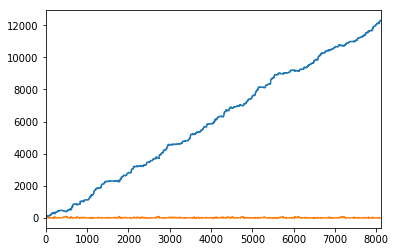

In [227]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [211]:
pl = pnl_target(data_out, max_odds = 4, min_odds = 1.1, fee = 0.1, 
                target_restrict = None, scale_with_pred = True, 
                stake = 40, scale_with_odds = False, min_pred = 0.5)

played games: 0.150816
mean : -3.405822
standard deviation: 107.043379
max drawdown: 4773.342215
winning ratio: 0.314476
sharpe: -0.318172


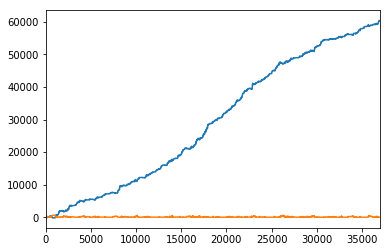

In [12]:
from matplotlib import pyplot as plt
pl["cum_pnl"].plot()
pl["drawdown"].plot()
plt.show()

In [13]:
pl.to_csv("pred_1.csv", sep = ";")

In [305]:
len(data_preprocessing)

137026

In [86]:
from sklearn.externals import joblib

class RFRPredictor():
    def __init__(self, pred_file, encoder_file, runners, stake = 4, target_restrict = None, 
                 scale_with_pred=None, scale_with_odds=None, min_odds = 1.01, 
                 max_odds = 1000, min_pred = 0):
        
        self.encoder_file = encoder_file
        self.pred_file = pred_file
        self.runners = runners
        self.stake = stake
        self.target_restrict = target_restrict
        self.scale_with_pred = scale_with_pred,
        self.scale_with_odds = scale_with_odds, 
        self.min_odds = min_odds
        self.max_odds = max_odds
        self.min_pred = min_pred
        self.models = self.read_models(self.pred_file, self.runners)
        self.encoder = self.read_encoder(self.encoder_file)
        
    def read_models(self, file, runners):
        models = {}
        for runner in runners:
            models[runner] = joblib.load(file+"_"+runner+".pkl")
        return models

    def read_encoder(self, file):
        return joblib.load(file+".pkl")

    def make_prediction(self, data):
        
        try:
            team1_label = self.encoder.transform([data["team1"]])[0]
            team2_label = self.encoder.transform([data["team2"]])[0]
        except ValueError:
            return {runner:-1000 for runner in runners}
        
        regressors = [[team1_label,team2_label,data["1"], data["x"], data["2"]]]
        print(regressors)
        pred = {}

        for runner in self.runners:
            pred[runner] = self.models[runner].predict(regressors)

        return pred

    def get_bet(self, odds):
        
        pred = self.make_prediction(odds)
        print(pred)
        target = self.runners[0]
        for runner in self.runners:
            if float(pred[runner]) > float(pred[target]):
                target = runner

        restricted = self.target_restrict is None or target in self.target_restrict

        if pred[target] > self.min_pred and float(odds[target])<self.max_odds \
                    and float(odds[target])>self.min_odds and restricted:
            
            stake_adjusted = self.stake

            if self.scale_with_odds:
                stake_adjusted = stake_adjusted / float(odds[target])

            if self.scale_with_pred:
                stake_adjusted = stake_adjusted * max(min(pred[target], 5), 0.5)
            return target, stake_adjusted
        else:
            return None, 0


pred_file = "predictor"    
encoder_file = "encoder"
runners = ["1","x","2"]

predictor = RFRPredictor(pred_file, encoder_file, runners, stake = 10, max_odds = 5, min_odds = 1.2, 
        scale_with_pred = True, scale_with_odds = False, target_restrict = None,
        min_pred = 0)

odds = data_preprocessing.iloc[0]

predictor.get_bet(odds)


[[5715, 10146, 2.5, 3.8999999999999999, 5.2000000000000002]]
{'1': array([ 0.38376238]), 'x': array([-0.34452114]), '2': array([-0.33114465])}


('1', 2.0)

In [87]:
print("sharpe: %f" % np.sqrt(100))

sharpe: 10.000000


In [97]:
odds = data_preprocessing.iloc[0]
odds["1"] = 1.5

predictor.get_bet(odds)

[[5715, 10146, 1.5, 3.8999999999999999, 5.2000000000000002]]
{'1': array([-0.71601151]), 'x': array([-0.46854076]), '2': array([-0.43885656])}


c:\users\betfair\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(None, 0)

In [90]:
odds

team1          Greenbay Hoppers FC
team2                       SAP FC
1                              2.9
x                              3.9
2                              5.2
pnl_1                        14.25
pnl_x                          -10
pnl_2                          -10
winner                           1
team1_label                   5715
team2_label                  10146
prob_1                         0.4
prob_x                     0.25641
prob_2                    0.192308
Name: 70594, dtype: object

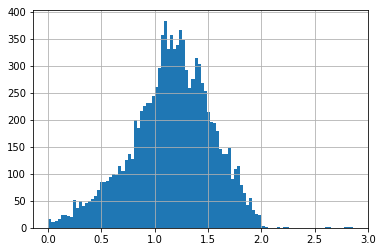

In [161]:
data_preprocessing[["prob_1", "prob_x", "prob_1"]].sum(axis = 1).hist(bins = 100)
plt.show()

In [109]:
data_preprocessing[data_preprocessing[["prob_1", "prob_x", "prob_1"]].sum(axis = 1)<0.1].to_clipboard()

In [110]:
a = (1, 2, 3)

In [111]:
a + (1, 2, 3)

(1, 2, 3, 1, 2, 3)

In [112]:
round(20.5555555,2)

20.56

In [163]:
data.to_clipboard(sep = ";")

In [195]:
len(data_preprocessing)

13293